# Part1

Pilot: ε-greedy with ε = 0.01
Pilot: ε-greedy with ε = 0.05
Pilot: ε-greedy with ε = 0.1
Pilot: ε-greedy with ε = 0.2
Pilot: ε-greedy with ε = 0.3
✅ Best ε from pilot: 0.05
Pilot: Gradient Bandit with α = 0.01
Pilot: Gradient Bandit with α = 0.05
Pilot: Gradient Bandit with α = 0.1
Pilot: Gradient Bandit with α = 0.2
Pilot: Gradient Bandit with α = 0.4
✅ Best α from pilot: 0.2
Final Run: greedy
Final Run: epsilon_greedy
Final Run: optimistic
Final Run: gradient
🎉 All plots saved:
- pilot_epsilon_greedy.png
- pilot_gradient_bandit.png
- final_avg_reward.png
- final_optimal_action.png


<Figure size 640x480 with 0 Axes>

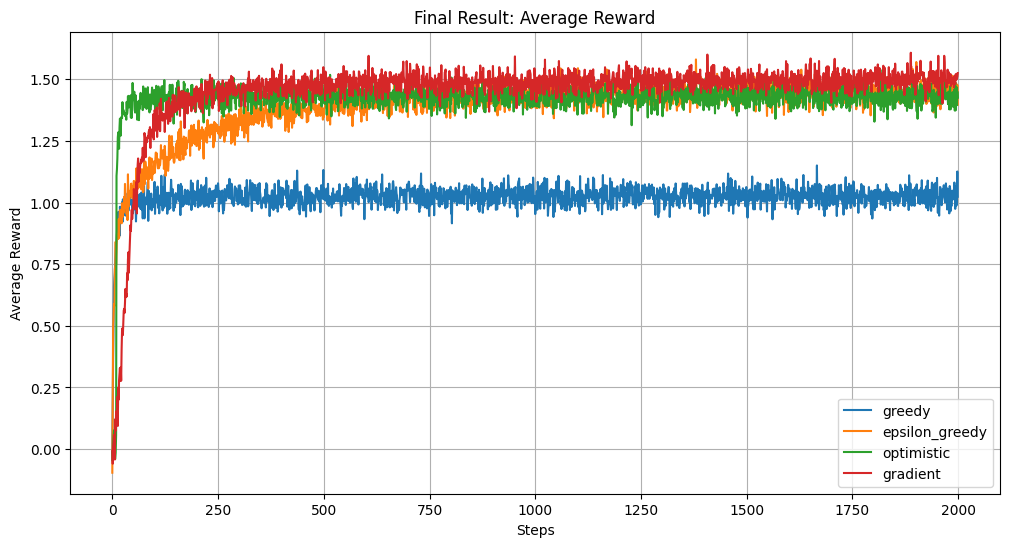

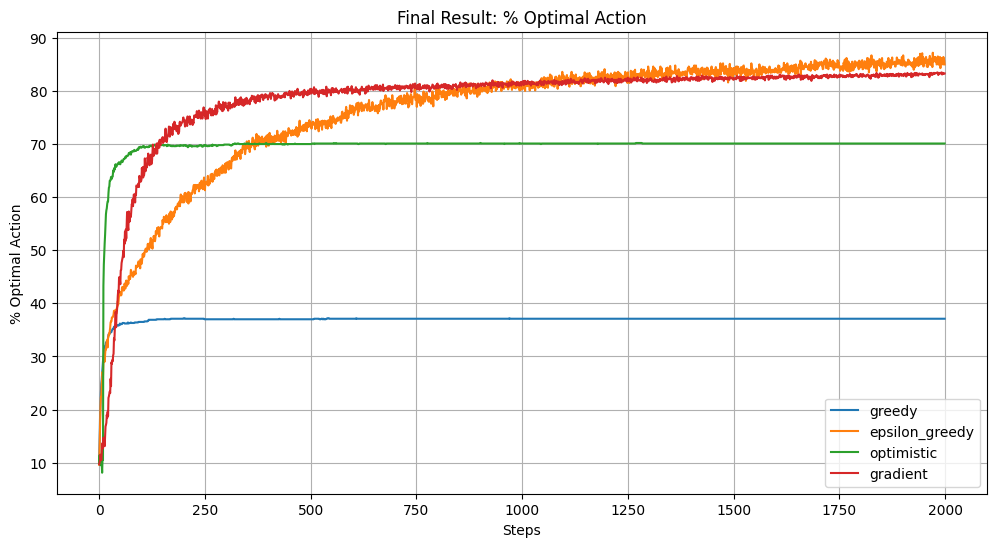

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ----- Settings -----
k = 10                     # Number of bandit arms
pilot_steps = 500         # Steps for pilot (tuning) experiments
pilot_runs = 100          # Runs for each pilot test
final_steps = 2000        # Steps for final experiment
final_runs = 1000         # Runs for each final experiment

# ----- Reward Function -----
# Simulate reward as a sample from N(true_mean, 1)
def bandit_reward(true_means):
    return np.random.normal(true_means, 1)

# ----- Bandit Algorithm Runner -----
# Runs one of the four algorithms over multiple simulations
def run_bandit(method, runs, steps, epsilon=0.1, alpha=0.1):
    rewards = np.zeros((runs, steps))           # Stores rewards for each run and step
    optimal_actions = np.zeros((runs, steps))   # Stores whether optimal action was chosen

    for run in range(runs):
        np.random.seed(run)                     # Ensures reproducibility across runs
        true_means = np.random.normal(0, 1, k)  # True reward for each arm
        optimal_action = np.argmax(true_means)  # Index of best arm

        # ----- Initialization -----
        if method in ['greedy', 'epsilon_greedy', 'optimistic']:
            Q = np.zeros(k)                     # Estimated values
            N = np.zeros(k)                     # Action counts
            if method == 'optimistic':
                optimistic_value = np.max(true_means) + 2.5758  # 99.5th percentile optimistic init
                Q.fill(optimistic_value)
        elif method == 'gradient':
            H = np.zeros(k)                     # Preference values for gradient method
            pi = np.ones(k) / k                 # Initial uniform policy
            R_avg = 0                           # Average reward tracker

        # ----- Interaction Loop -----
        for t in range(steps):
            # ----- Action Selection -----
            if method in ['greedy', 'optimistic']:
                best_actions = np.argwhere(Q == np.max(Q)).flatten()
                action = np.random.choice(best_actions)        # Break ties randomly
            elif method == 'epsilon_greedy':
                if np.random.rand() < epsilon:
                    action = np.random.choice(k)               # Explore
                else:
                    best_actions = np.argwhere(Q == np.max(Q)).flatten()
                    action = np.random.choice(best_actions)    # Exploit
            elif method == 'gradient':
                pi = np.exp(H) / np.sum(np.exp(H))             # Softmax to get probabilities
                action = np.random.choice(k, p=pi)             # Sample based on pi

            # ----- Receive Reward -----
            reward = bandit_reward(true_means[action])

            # ----- Update Estimates -----
            if method in ['greedy', 'epsilon_greedy', 'optimistic']:
                N[action] += 1
                Q[action] += (reward - Q[action]) / N[action]  # Incremental average
            elif method == 'gradient':
                R_avg += (reward - R_avg) / (t + 1)            # Update running average
                for a in range(k):
                    if a == action:
                        H[a] += alpha * (reward - R_avg) * (1 - pi[a])
                    else:
                        H[a] -= alpha * (reward - R_avg) * pi[a]

            # ----- Track Performance -----
            rewards[run, t] = reward
            optimal_actions[run, t] = int(action == optimal_action)

    # ----- Average over Runs -----
    avg_rewards = np.mean(rewards, axis=0)
    opt_action_percent = 100 * np.mean(optimal_actions, axis=0)
    return avg_rewards, opt_action_percent

# ===== PILOT TUNING FOR EPSILON-GREEDY =====
epsilons = [0.01, 0.05, 0.1, 0.2, 0.3]     # Candidate epsilon values
eps_rewards = {}

# Run each epsilon setting and store average reward
for eps in epsilons:
    print(f"Pilot: ε-greedy with ε = {eps}")
    avg_r, _ = run_bandit('epsilon_greedy', pilot_runs, pilot_steps, epsilon=eps)
    eps_rewards[eps] = avg_r
    plt.plot(avg_r, label=f'ε={eps}')

# Plot epsilon-greedy pilot results
plt.title("Pilot Run: Epsilon-Greedy")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend()
plt.grid(True)
plt.savefig("pilot_epsilon_greedy.png")
plt.clf()  # Clear plot for next figure

# Select epsilon with best final average reward
best_epsilon = max(eps_rewards, key=lambda e: np.mean(eps_rewards[e][-100:]))
print(f"✅ Best ε from pilot: {best_epsilon}")

# ===== PILOT TUNING FOR GRADIENT BANDIT =====
alphas = [0.01, 0.05, 0.1, 0.2, 0.4]      # Candidate alpha values
alpha_rewards = {}

# Run each alpha and collect average rewards
for alpha in alphas:
    print(f"Pilot: Gradient Bandit with α = {alpha}")
    avg_r, _ = run_bandit('gradient', pilot_runs, pilot_steps, alpha=alpha)
    alpha_rewards[alpha] = avg_r
    plt.plot(avg_r, label=f'α={alpha}')

# Plot gradient pilot results
plt.title("Pilot Run: Gradient Bandit")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend()
plt.grid(True)
plt.savefig("pilot_gradient_bandit.png")
plt.clf()

# Select best alpha based on last 100 steps
best_alpha = max(alpha_rewards, key=lambda a: np.mean(alpha_rewards[a][-100:]))
print(f"✅ Best α from pilot: {best_alpha}")

# ===== FINAL EXPERIMENT WITH BEST PARAMETERS =====
methods = {
    'greedy': {},
    'epsilon_greedy': {'epsilon': best_epsilon},
    'optimistic': {},
    'gradient': {'alpha': best_alpha}
}

results = {}
# Run all four strategies with tuned parameters
for method, params in methods.items():
    print(f"Final Run: {method}")
    avg_r, opt_p = run_bandit(method, final_runs, final_steps, **params)
    results[method] = {'avg_reward': avg_r, 'optimal_action': opt_p}

# ----- Final Plots -----
# Plot average reward
plt.figure(figsize=(12, 6))
for method in results:
    plt.plot(results[method]['avg_reward'], label=method)
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.title("Final Result: Average Reward")
plt.legend()
plt.grid(True)
plt.savefig("final_avg_reward.png")

# Plot percentage of optimal actions
plt.figure(figsize=(12, 6))
for method in results:
    plt.plot(results[method]['optimal_action'], label=method)
plt.xlabel("Steps")
plt.ylabel("% Optimal Action")
plt.title("Final Result: % Optimal Action")
plt.legend()
plt.grid(True)
plt.savefig("final_optimal_action.png")

# ----- Done -----
print("🎉 All plots saved:")
print("- pilot_epsilon_greedy.png")
print("- pilot_gradient_bandit.png")
print("- final_avg_reward.png")
print("- final_optimal_action.png")


# Part2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bars

# --- Configuration ---
k = 10                            # Number of arms
steps = 2000                      # Number of time steps in each simulation
runs = 1000                        # Number of independent simulation runs (can increase to 1000 for final submission)
drift_std = 0.01                  # Std. dev. for drift noise (N(0, 0.01^2))
kappa = 0.5                       # Mean reversion coefficient
change_point = 501               # Time step at which abrupt change occurs
alpha_values = [0.05, 0.1, 0.2]   # Learning rates for gradient bandit (for pilot runs)
epsilon_values = [0.05, 0.1, 0.2] # Exploration rates for epsilon-greedy (for pilot runs)

# --- Set up consistent randomness for comparability ---
np.random.seed(0)
drift_seeds = np.random.randint(0, 10000, size=k)  # One drift stream per arm
np.random.seed(42)
permutation = np.random.permutation(k)             # Used for abrupt change (shuffling arms)

# --- Drift Generator ---
def generate_drift(drift_type='normal'):
    """
    Generate drift or mean-reverting drift sequences for each arm.
    """
    mu = np.zeros((k, steps))  # Mean rewards over time
    for i in range(k):
        np.random.seed(drift_seeds[i])
        noise = np.random.normal(0, drift_std, size=steps)
        mu[i, 0] = np.random.normal(0, 1)  # Initial mean
        for t in range(1, steps):
            if drift_type == 'normal':
                mu[i, t] = mu[i, t - 1] + noise[t]
            elif drift_type == 'mean_reverting':
                mu[i, t] = kappa * mu[i, t - 1] + noise[t]
    return mu

# --- Apply Abrupt Change ---
def apply_abrupt_change(mu):
    """
    At change_point, swap each arm’s mean with a new permuted one.
    """
    mu_copy = mu.copy()
    for i in range(k):
        mu_copy[i, change_point:] = mu[permutation[i], change_point:]
    return mu_copy

# --- Reward Sampler ---
def sample_reward(mu, action, t):
    """
    Sample reward from a normal distribution centered at μ[action, t]
    """
    return np.random.normal(mu[action, t], 1)

# --- Bandit Algorithm Wrappers ---
# These call the unified run_bandit function with different settings
def greedy(mu, reset_at=None):
    return run_bandit(mu, method='greedy', epsilon=0.0, alpha=None, reset_at=reset_at)

def epsilon_greedy(mu, epsilon, reset_at=None):
    return run_bandit(mu, method='epsilon', epsilon=epsilon, alpha=None, reset_at=reset_at)

def optimistic(mu, init_value=5.0, reset_at=None):
    return run_bandit(mu, method='optimistic', epsilon=0.0, alpha=None, init_val=init_value, reset_at=reset_at)

def gradient(mu, alpha, reset_at=None):
    return run_bandit(mu, method='gradient', epsilon=None, alpha=alpha, reset_at=reset_at)

# --- Unified Runner Function ---
def run_bandit(mu, method, epsilon=None, alpha=None, init_val=0.0, reset_at=None):
    """
    Run any of the four methods using the provided drift/abrupt μ table.
    """
    avg_rewards = np.zeros(steps)
    optimal_actions = np.zeros(steps)

    for _ in tqdm(range(runs), leave=False):  # Show progress bar
        Q = np.full(k, init_val)     # Action-value estimates
        N = np.zeros(k)              # Action count (for averaging)
        H = np.zeros(k)              # Preference vector (for gradient)
        pi = np.ones(k) / k          # Initial policy (uniform)

        rewards = np.zeros(steps)
        optimal = np.zeros(steps)

        for t in range(steps):
            opt_action = np.argmax(mu[:, t])  # Optimal action at time t

            # --- Action Selection ---
            if method == 'gradient':
                action = np.random.choice(k, p=pi)
            elif method == 'epsilon':
                if np.random.rand() < epsilon:
                    action = np.random.choice(k)
                else:
                    action = np.random.choice(np.flatnonzero(Q == Q.max()))
            else:
                action = np.random.choice(np.flatnonzero(Q == Q.max()))

            # --- Reward & Update ---
            r = sample_reward(mu, action, t)

            if method == 'gradient':
                avg_r = np.dot(pi, Q)
                for a in range(k):
                    H[a] += alpha * (r - avg_r) * ((1 if a == action else 0) - pi[a])
                # Numerical stability trick for softmax
                max_h = np.max(H)
                exp = np.exp(H - max_h)
                pi = exp / np.sum(exp)
            else:
                N[action] += 1
                Q[action] += (r - Q[action]) / N[action]

            # --- Reset Q-values at abrupt change ---
            if reset_at is not None and t == reset_at:
                Q = np.full(k, init_val)
                N = np.zeros(k)
                H = np.zeros(k)
                pi = np.ones(k) / k

            rewards[t] = r
            optimal[t] = int(action == opt_action)

        avg_rewards += rewards
        optimal_actions += optimal

    # Average over all simulation runs
    avg_rewards /= runs
    optimal_actions = 100 * optimal_actions / runs
    return avg_rewards, optimal_actions

# --- Pilot Runs for Parameter Tuning ---
def pilot_run(method, values, drift_type='normal'):
    """
    Runs pilot simulations for tuning epsilon or alpha.
    """
    mu = generate_drift(drift_type)
    results = {}
    for val in values:
        if method == 'epsilon':
            rewards, _ = epsilon_greedy(mu, epsilon=val)
        elif method == 'gradient':
            rewards, _ = gradient(mu, alpha=val)
        results[val] = rewards
    return results

# --- Plotting Results ---
def plot_results(results, title, ylabel, filename):
    """
    Save plot comparing different algorithms or parameter values.
    """
    plt.figure(figsize=(10, 6))
    for label, data in results.items():
        plt.plot(data, label=str(label))
    plt.title(title)
    plt.xlabel("Steps")
    plt.ylabel(ylabel)
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

# --- Run Pilot Experiments to Find Best ε and α ---
epsilon_results = pilot_run('epsilon', epsilon_values)
gradient_results = pilot_run('gradient', alpha_values)

best_epsilon = max(epsilon_results.items(), key=lambda x: np.mean(x[1]))[0]
best_alpha = max(gradient_results.items(), key=lambda x: np.mean(x[1]))[0]

print(f"✅ Best epsilon: {best_epsilon}")
print(f"✅ Best alpha: {best_alpha}")

# --- Define Non-Stationary Scenarios ---
scenarios = {
    "Drift": generate_drift('normal'),
    "Mean-Reverting Drift": generate_drift('mean_reverting'),
    "Abrupt Change No Reset": apply_abrupt_change(generate_drift('normal')),
    "Abrupt Change With Reset": apply_abrupt_change(generate_drift('normal')),
}

# --- Run Final Experiments on All Scenarios and Methods ---
final_results = {}
for scenario_name, mu in scenarios.items():
    reset = change_point if "With Reset" in scenario_name else None
    final_results[scenario_name] = {
        "Greedy": greedy(mu, reset_at=reset),
        "Epsilon-Greedy": epsilon_greedy(mu, best_epsilon, reset_at=reset),
        "Optimistic": optimistic(mu, init_value=5.0, reset_at=reset),
        "Gradient": gradient(mu, best_alpha, reset_at=reset),
    }

# --- Save Comparison Plots for Each Scenario ---
for metric in ["avg_reward", "optimal_action"]:
    for scenario_name in scenarios:
        data = {
            method: final_results[scenario_name][method][0 if metric == "avg_reward" else 1]
            for method in final_results[scenario_name]
        }
        title = f"{scenario_name} - {'Average Reward' if metric == 'avg_reward' else '% Optimal Action'}"
        ylabel = "Reward" if metric == "avg_reward" else "Percentage"
        filename = f"{scenario_name.replace(' ', '_')}_{metric}.png"
        plot_results(data, title, ylabel, filename)
